<a href="https://colab.research.google.com/github/jhonKifle/Mnist-digit-classifier---Regularization-L2-/blob/main/MNIST_classifier_using_NN_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST classification using Regularization (L2)**

In this demo, the previous classification is used to show for enhancing Overfitting of the model. Overfitting is a common problem in machine learning where a model learns the training data too well, capturing not only the underlying patterns but also noise and irrelevant details. As a result, the model performs well on the training data but fails to generalize to new, unseen data.

L2 regularization helps prevent overfitting by adding a penalty term to the loss function that penalizes large weights.

When L2 regularization is applied, the gradient descent algorithm updates the weights not only based on the original loss but also by including a term that shrinks the weights. The parameter update rule with L2 regularization becomes:

The weight update for NN with no regularizations was as follows:

 $$
 w′=w−η\frac{∂C_0}{∂w} \tag{1}
 $$
 $$
b'= b−η\frac{∂C0}{∂b} \tag{2}
$$
Introducing the regularizations (L2), the learning rule for the weights becomes:
 $$
 w′=w(1−\frac{ηλ}{n})−η\frac{∂C_0}{∂w} \tag{3}
 $$
Biases are typically not regularized, but weights are, as biases control the overall position of the function, while weights control its shape and complexity.

In [ ]:
import numpy as np
import random
import pandas as pd
!pip install scienceplots
import matplotlib.pyplot as plt
import scienceplots

In [ ]:
#Hot-encodding for output
def one_hot(y):
    one_hot_y = [np.zeros((10,1)) for a in y]
    for i,e in zip(y,one_hot_y):
      e[i] = 1
    return one_hot_y
#Dataset Preprocesing
def preprocess():
  #load dataset
  train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
  test = pd.read_csv('/content/sample_data/mnist_test.csv')

  #NB size of train, & test dataset in this case is 19999 and 9999 respectively.
  #To make is fit to a size of batch of 10, I duplicate the first row as following 2 line of codes.
  train = train._append(train.head(1))
  test = test._append(test.head(1))

  valid = train.sample(frac=0.2)
  train = train.drop(valid.index)

  train_X = train.iloc[:,1:]
  train_y = train.iloc[:,0]

  train_X = train_X/255
  train_X = [np.reshape(x, (784, 1)) for x in train_X.values]

  valid_X = valid.iloc[:,1:]
  valid_X = valid_X/255
  valid_X = [np.reshape(x, (784, 1)) for x in valid_X.values]

  valid_y = valid.iloc[:,0]

  test_X = test.iloc[:,1:]
  test_X = test_X/255
  test_X = [np.reshape(x, (784, 1)) for x in test_X.values]
  test_y = test.iloc[:,0]

  train_y = train_y.to_numpy()
  train_y = one_hot(train_y)
  valid_y = valid_y.to_numpy()
  test_y = test_y.to_numpy()
  return list(zip(train_X,train_y)),list(zip(valid_X,valid_y)),list(zip(test_X,test_y))

In [ ]:
class Cost:
  @staticmethod
  def Entropy(a,y):
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
  @staticmethod
  def delta(a,y):
    return (a-y)
class NN:
    def __init__(self, sizes,cost=Cost):
        self.layers = len(sizes)
        self.sizes = sizes
        self.cost = cost
        self.weightInitializer()
        self.copy_weights = self.weights.copy()
        self.copy_biases = self.biases.copy()

    # weights are inialized with gaussian variable of mean = 0 and sd = 1/sqrt(inputs)
    def weightInitializer(self):
        self.weights = [np.random.randn(y,x)   for x,y in zip(self.sizes[:-1],self.sizes[1:])]
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
    def feedforward(self,a):
        for w,b in zip(self.weights,self.biases):
            a = self.sigmoid(np.dot(w,a)+b)
        return a
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))
    def sigmoid_prime(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    def backprop(self,x,y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
          z = np.dot(w, activation)+b
          zs.append(z)
          activation = self.sigmoid(z)
          activations.append(activation)


        delta = (self.cost).delta(activations[-1],y) * self.sigmoid_prime(zs[-1])

        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2,self.layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(),delta)*sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta,activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    def update_mini_batch(self,mini_batch,eta,lmbda,n):
      nabla_b = [np.zeros(b.shape) for b in self.biases]
      nabla_w = [np.zeros(w.shape) for w in self.weights]
      for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
      self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
      self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
    #Stochastic gradient Decsent with regularization (L2) - Lambda = 0.0
    def SGD(self,training_data,epochs,mini_batch_size,eta,lmbda=0.0,test_data=None):
      if lmbda == 0.0:
        print("No Regularization")
      else:
        print("\nRegularization (L2) with lambda =",lmbda)
      accuracy = []
      if test_data:
        n_test = len(test_data)
      for j in range(epochs):
        #random.shuffle(training_data)
        for x in range(0,len(training_data),mini_batch_size):
          self.update_mini_batch(training_data[x:x+mini_batch_size],eta,lmbda,len(training_data))
        accuracy.append(self.evaluate(test_data))
        print("\r>>>Training progress...",int((j+1)*100/epochs),'%, accuracy =',100*(accuracy[-1]/n_test),end='')
        '''
        if test_data:
          err = self.evaluate(test_data)
          print("Epoch {} : {} / {} ({}%)".format(j,err,n_test,100*(err/n_test)))
        else:
          print("Epoch {} complete".format(j))
        '''
      return accuracy
    def evaluate(self,test_data):
      test_results = [(np.argmax(self.feedforward(x)),y) for (x,y) in test_data]
      return sum(int(x==y) for (x,y) in test_results)


net = NN([784,30,10])
training_set, valid_set, test_set = preprocess()
accuracy_nonReg = net.SGD(training_set, 30, 10, 3.0, lmbda=0.0, test_data=valid_set)
#net.SGD(training_set, 30, 10, 3.0, test_data=valid_set)
net.weights = net.copy_weights
net.biases  = net.copy_biases
accuracy_Reg = net.SGD(training_set, 30, 10, 3.0, lmbda=2.0, test_data=valid_set)




No Regularization
>>>Training progress... 100 %, accuracy = 81.425
Regularization (L2) with lambda = 2.0
>>>Training progress... 100 %, accuracy = 93.30000000000001

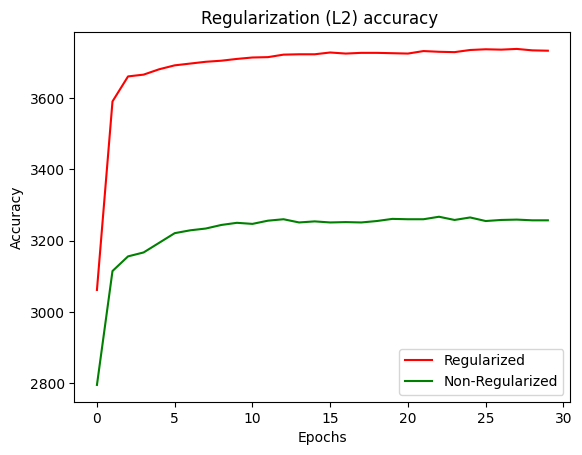

In [ ]:
X = np.arange(0,30)
plt.plot(X, accuracy_Reg, color='r', label='Regularized')
plt.plot(X, accuracy_nonReg, color='g', label='Non-Regularized')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Regularization (L2) accuracy ")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

##Analysis of Regularazation effect
Intuitively, the effect of regularization is to make it so the network prefers to learn small weights, all other things being equal. Large weights will only be allowed if they considerably improve the first part of the cost function. In another word, regularization can be viewed as a way of compromising between finding small weights and minimizing the original cost function.

As showns in above, the classification accuracy on the validation data is up, from 81.42 percent when running unregularized, to 93.3 percent. From this we can understand that regularization act as a way to reduce overfitting and to increase classification accuracies.

Selecting the value for the L2 regularization parameter requires balancing between preventing overfitting and maintaining model performance. The optimal value often depends on the problem, dataset, and model type.